## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder

from torchvision.models import alexnet

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

### 0. Preparar o Setup

In [60]:
PATH_TRAIN = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/train'
PATH_TEST = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/val'

BATCH_SIZE = 32

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


### 1. Preparar os dados

In [62]:
transform = Compose(
        [ToTensor(),
         Resize((224, 224),antialias=True),
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [63]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

# Importar dataset

train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
val_dataset = ImageFolder(PATH_TEST, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 2. Definir Modelo

In [64]:
M_alexnet = alexnet(weights=None) # rede sem treino

num_classes = len(train_dataset.classes)
M_alexnet.classifier[6] = torch.nn.Linear(4096, num_classes) # alteração na camada de saída

In [65]:
# função de perda e otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(M_alexnet.parameters(), lr=0.001, momentum=0.9)

### 3. Treinar o Modelo

In [66]:
EPOCH = 5

for epoch in range(EPOCH):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = M_alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.6930070321482441
Epoch 2, Loss: 0.6926914944115098
Epoch 3, Loss: 0.6918811989605211
Epoch 4, Loss: 0.6899592525692193
Epoch 5, Loss: 0.6718021857179028


### 4. Avaliar o modelo

In [67]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    device = next(model.parameters()).device
    
    model.eval()  # Garantir que o modelo está no modo de avaliação
    
    with torch.no_grad():  # Desativar o cálculo de gradientes durante a avaliação
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            yprev = model(inputs)
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))
            predictions.append(yprev)
            actual_values.append(actual)
            
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)
    
    return actual_values, predictions

In [68]:
def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1
        else:
            falhou += 1
    
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

In [69]:
def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12},
                fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [71]:
actual_values, predictions = evaluate_model(val_loader, M_alexnet)
display_predictions(actual_values, predictions )

real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[1]
Accuracy: 0.468

acertou:281 falhou:319


In [72]:
print(classification_report(actual_values, predictions))

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       360
           1       0.40      0.63      0.49       240

    accuracy                           0.47       600
   macro avg       0.49      0.50      0.47       600
weighted avg       0.51      0.47      0.46       600



In [73]:
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=['fratured', 'not fractured']
cm = confusion_matrix(actual_values, predictions)
print (cm)

[[130 230]
 [ 89 151]]


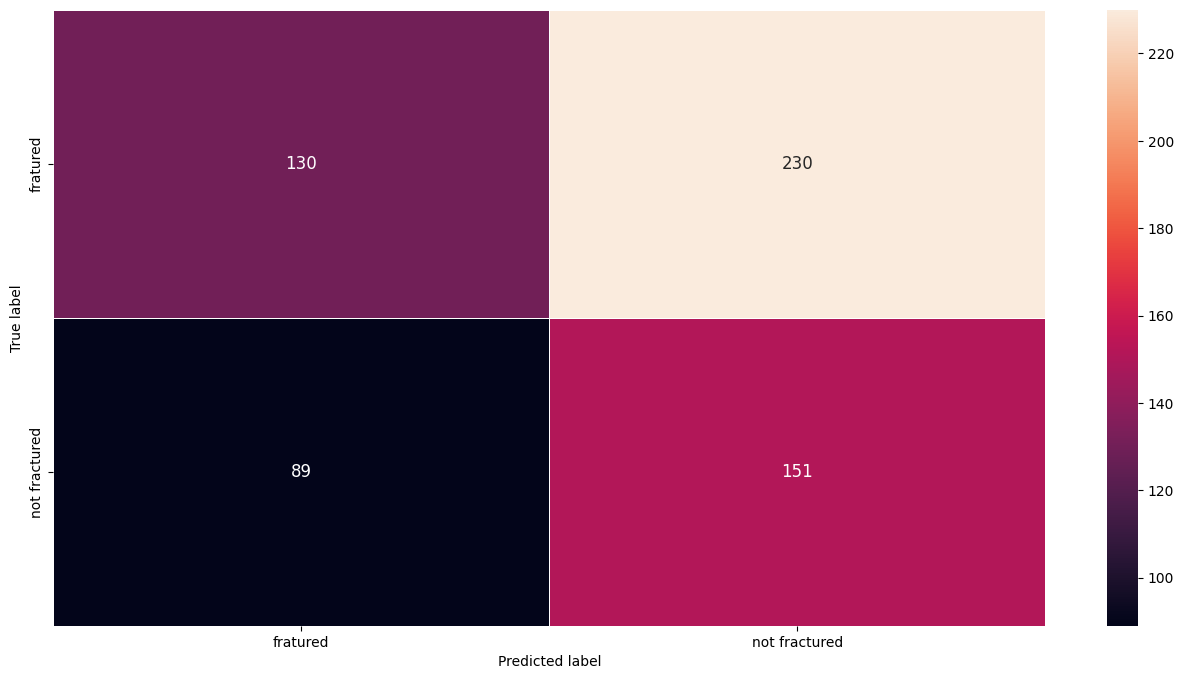

In [74]:
display_confusion_matrix(cm,list_classes)